In [45]:
"""
Implementation of Pairs Strategy
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from pandas_datareader import data
from statsmodels.tsa.stattools import coint

In [46]:
# we define the functions we need
def load_financial_data(symbols, start_date,end_date,output):
    try:
        df = pd.read_pickle(output)
    except FileNotFoundError:
        df = data.DataReader(symbols,'yahoo',start_date,end_date)
        df.to_pickle(output)
    return df

In [47]:
# we define a function for finding cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n,n)) 
    keys = data.keys() # columns names
    pairs = []
    for i in range(n):
        for j in range(i+1,n):
            res = coint(data[keys[i]],data[keys[j]])
            # coint: return [coint)t,pvalue,crit_value]
            pvalue_matrix[i,j] = res[1]
            # we set the alpha to be 0.02
            if res[1] < 0.02:
                # we collect valid pairs
                pairs.append((keys[i],keys[j]))
    return pvalue_matrix, pairs

In [48]:
# we load many stocks to find the cointegrated pairs
# from 2000 to 2020
symbols = ['SPY','AAPL','ADBE','LUV','MSFT','SKYW','QCOM', 'HPQ','JNPR','AMD','IBM']
data = load_financial_data(symbols, '2000-01-01','2020-01-01','group_data.pkl')

In [49]:
# we find the pairs
pvalues,pairs = find_cointegrated_pairs(data['Adj Close']) # there is another matrix inside data['Adj Close']
pairs

[('ADBE', 'MSFT'), ('JNPR', 'AMD'), ('JNPR', 'IBM')]

<AxesSubplot:>

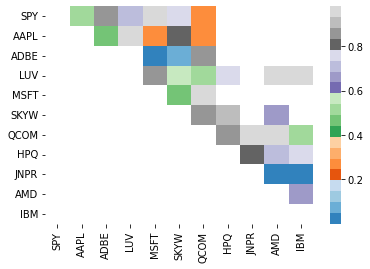

In [50]:
# we use seaborn to visualize the heat map
# cmap: color of the map
# we use mask to hid the p values >= 0.98
seaborn.heatmap(pvalues,xticklabels = symbols, yticklabels = symbols, cmap = 'tab20c',mask = (pvalues >= 0.98))

In [66]:
# we randomly create two series to show the idea of pairs trading
np.random.seed(777)
# we genernate symbol1
symbol1_returns = np.random.normal(0,1,100) # draw random samples from a gaussian distribution
symbol1_returns

array([-0.46820879, -0.82282485, -0.0653801 , -0.71336192,  0.90635089,
        0.76623673,  0.82605407, -1.32368279, -1.75244452,  1.00244907,
        0.54480945,  1.8951609 , -0.76935745, -1.40309592, -0.63246751,
       -0.55887367, -1.23323138, -0.43950352,  0.91478726,  0.26504093,
       -1.38337015,  0.6855118 ,  0.45609091, -0.46137426,  0.0947003 ,
       -1.54281161,  2.4793696 ,  0.45686676, -0.31387278,  0.02103738,
        0.96079316,  0.0584829 , -0.44603217,  0.31919714,  0.84116862,
       -1.53276199, -0.28158426,  1.74445271, -0.67423891,  0.58840123,
        1.80436346,  2.05625026,  1.45458168, -0.13841169,  0.34287188,
       -0.72761848, -1.4039461 , -1.24061119, -0.44348217, -0.04732516,
        0.75768436, -0.15208593, -0.27127901, -0.59983997, -2.02690413,
        0.3303424 , -0.330831  , -0.03494216,  0.28974804, -0.60626995,
       -0.26840428,  1.19147752,  0.15761331,  1.17482475,  1.32091002,
       -0.84803729,  0.7457074 , -0.3116213 , -1.05106538, -1.07

In [67]:
# we create the price based on the returns
symbol1_prices = pd.Series(np.cumsum(symbol1_returns),name = 'Symbol1')+10
symbol1_prices

0      9.531791
1      8.708966
2      8.643586
3      7.930224
4      8.836575
        ...    
95    12.228531
96    11.322239
97     9.860114
98     9.182549
99    10.705353
Name: Symbol1, Length: 100, dtype: float64

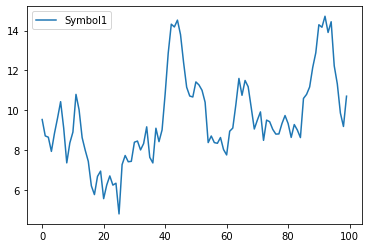

In [68]:
# now we get a simulated stock price with mean = 0, std = 1
symbol1_prices.plot()
plt.legend()

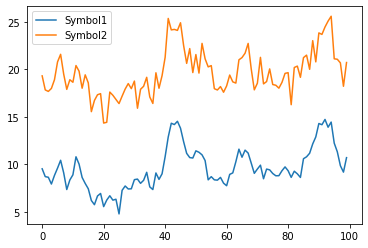

In [69]:
# we build the symbol2 stock prices based on symbol1
# that is, we just add some nosies to symbol1's prices 
# at the same time, we want to make symbol2 have the same action as symbol1
# but they are in different price intervals
# we show the new graph
noise = np.random.normal(0,1,100)
symbol2_prices = symbol1_prices+noise+10 # we separate them
symbol2_prices.name = 'Symbol2'
symbol1_prices.plot()
symbol2_prices.plot()
plt.legend()

In [70]:
# now we check the cointegration
socre,pvalue,_ = coint(symbol1_prices, symbol2_prices) # _: return the value of last executed expression values
# the p score is 3.705053079365829e-11
# meaning that we can reject the null hypothesis
# the two prices are cointegrated
pvalue

3.705053079365829e-11

In [71]:
# we define a z-score function
# for learning how much a data point deviates from the mean of a group 
# in the representation of the standard deviation
def z_score(series):
    return (series - np.mean(series)) / np.std(series)

<AxesSubplot:>

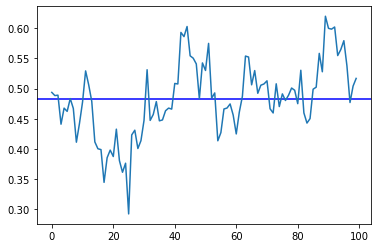

In [77]:
# we use the ratios between two symbol prices as the input of z-score
# we draw the ratios first
ratios = symbol1_prices / symbol2_prices
plt.axhline(np.mean(ratios), color = 'b')
ratios.plot()

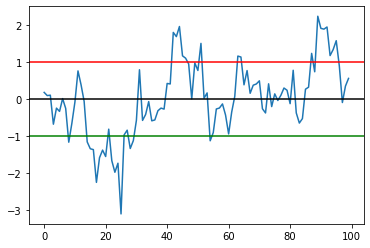

In [78]:
%matplotlib inline  
# now we draw the graphs where we may place orders
z_score(ratios).plot()
plt.axhline(z_score(ratios).mean(),color = 'k') # the black line is the mean value, 0
plt.axhline(1.0,color = 'r') # 1,-1 are arbitrary threshold we choose for simplification
plt.axhline(-1.0,color = 'g')

In [74]:
# every time the z-score touches the red / green line, there is a trading signal

# through mean-reversion, we know that when z-score(ratios) touches -1, it is going to go up
# from our definition, ratios = symbol1_price / symbol2_price = low_price / high_price
# if ratio increases, symbol1_price will increase and symbol2_price will decrease
# thus, we long symbol1 and short symbol2 for green line

# same logic for red line
# through mean-reversion, we know that when z-score(ratios) touches 1, it is going to go down
# if ratios decreases, symbol1_price will decrease and symbol2_price will increase
# thus, we short symbol1 and long symbol2 for red line

In [81]:
# we make a copy of the two symbols to make the buy/sell signal for each symbol
symbol1_buy = symbol1_prices.copy()
symbol1_sell = symbol1_prices.copy()

symbol2_buy = symbol2_prices.copy()
symbol2_sell = symbol2_prices.copy()

<AxesSubplot:>

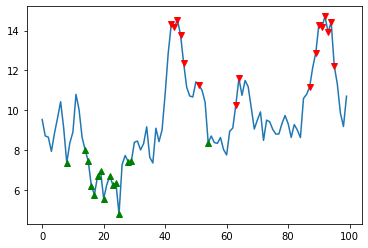

In [93]:
# we visualize the buy/sell signals for each symbol
# the green marker represents buy
# and the red marker represents sell
symbol1_prices.plot()
symbol1_buy[z_score(ratios) > -1] = 0
symbol1_sell[z_score(ratios) < 1] = 0
symbol1_buy[symbol1_buy != 0].plot(color ='g',marker = '^',linestyle="None")
symbol1_sell[symbol1_sell != 0].plot(color = 'r',marker = 'v',linestyle = 'None')

<AxesSubplot:>

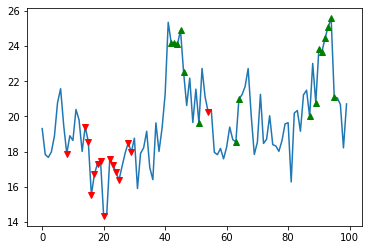

In [94]:
symbol2_prices.plot()
symbol2_buy[z_score(ratios) < 1] = 0
symbol2_sell[z_score(ratios) > -1] = 0
symbol2_buy[symbol2_buy != 0].plot(color ='g',marker = '^',linestyle="None")
symbol2_sell[symbol2_sell != 0].plot(color = 'r',marker = 'v',linestyle = 'None')

<AxesSubplot:>

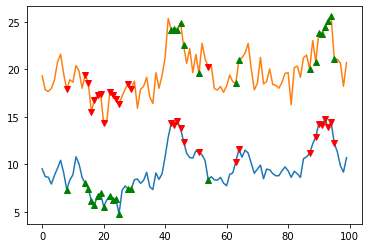

In [95]:
# we put them together
symbol1_prices.plot()
symbol1_buy[z_score(ratios) > -1] = 0
symbol1_sell[z_score(ratios) < 1] = 0
symbol1_buy[symbol1_buy != 0].plot(color ='g',marker = '^',linestyle="None")
symbol1_sell[symbol1_sell != 0].plot(color = 'r',marker = 'v',linestyle = 'None')

symbol2_prices.plot()
symbol2_buy[z_score(ratios) < 1] = 0
symbol2_sell[z_score(ratios) > -1] = 0
symbol2_buy[symbol2_buy != 0].plot(color ='g',marker = '^',linestyle="None")
symbol2_sell[symbol2_sell != 0].plot(color = 'r',marker = 'v',linestyle = 'None')

In [96]:
# now the example has clearly explained the pair trading
# we use the three we have found to visualize them

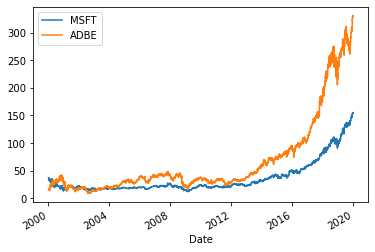

In [100]:
# ('ADBE', 'MSFT')
symbol1_prices = data['Adj Close']['MSFT']
symbol2_prices = data['Adj Close']['ADBE']

symbol1_prices.plot()
symbol2_prices.plot()
plt.legend()

<AxesSubplot:xlabel='Date'>

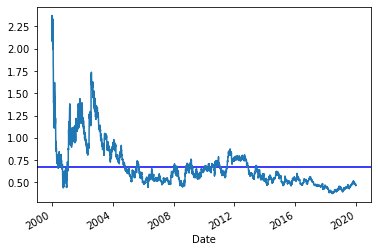

In [101]:
ratios = symbol1_prices / symbol2_prices
plt.axhline(np.mean(ratios), color = 'b')
ratios.plot()

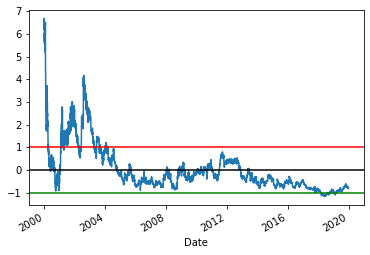

In [102]:
# now we draw the graphs where we may place orders
z_score(ratios).plot()
plt.axhline(z_score(ratios).mean(),color = 'k') # the black line is the mean value, 0
plt.axhline(1.0,color = 'r') # 1,-1 are arbitrary threshold we choose for simplification
plt.axhline(-1.0,color = 'g')

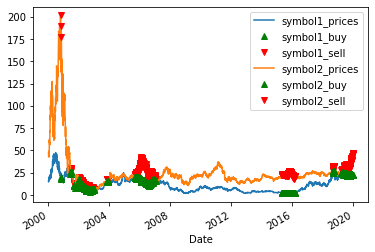

In [109]:
# we make a copy of the two symbols to make the buy/sell signal for each symbol
symbol1_buy = symbol1_prices.copy()
symbol1_sell = symbol1_prices.copy()

symbol2_buy = symbol2_prices.copy()
symbol2_sell = symbol2_prices.copy()

# we put them together
symbol1_prices.plot()
symbol1_buy[z_score(ratios) > -1] = 0
symbol1_sell[z_score(ratios) < 1] = 0
symbol1_buy[symbol1_buy != 0].plot(color ='g',marker = '^',linestyle="None")
symbol1_sell[symbol1_sell != 0].plot(color = 'r',marker = 'v',linestyle = 'None')

symbol2_prices.plot()
symbol2_buy[z_score(ratios) < 1] = 0
symbol2_sell[z_score(ratios) > -1] = 0
symbol2_buy[symbol2_buy != 0].plot(color ='g',marker = '^',linestyle="None")
symbol2_sell[symbol2_sell != 0].plot(color = 'r',marker = 'v',linestyle = 'None')
plt.legend(['symbol1_prices','symbol1_buy','symbol1_sell','symbol2_prices','symbol2_buy','symbol2_sell'])

In [110]:
# we can see that the buy-sell actions are clotted in some time intervals
# we just limit the number of orders
# three ways:
# 1. limit positions
# 2. limit number of orders
# 3. set a higher z-score threshold

In [111]:
# at the same time, while we talk about when to enter the trade,
# we don't talk about when to exit the trade
# we enter the trade when the first time we see the buy/sell signals
# and we exit once we enter the interval of the threshold, that is, -1 and 1 in our example
# with those in minds, we can build our strategy

In [115]:
pair_strategy = pd.DataFrame(index = symbol1_prices.index)
pair_strategy['symbol1_price'] = symbol1_prices
pair_strategy['symbol1_buy'] = np.zeros(len(symbol1_prices))
pair_strategy['symbol1_sell'] = np.zeros(len(symbol1_prices))
pair_strategy['symbol2_buy'] = np.zeros(len(symbol1_prices))
pair_strategy['symbol2_sell'] = np.zeros(len(symbol1_prices))

In [118]:
# for convenience, we limit the position to only 1 share, either long or short
# the position represents the position in symbol1
# 0: neutral position
position = 0
for i in range(len(symbol1_prices)):
    s1_price = symbol1_prices[i]
    s2_price = symbol2_prices[i]
    if not position and symbol1_buy[i] != 0: # not position: meaning position is 0, and we can long s1, short s2
        pair_strategy['symbol1_buy'][i] = s1_price
        pair_strategy['symbol2_sell'][i] = s2_price
        position = 1
    elif not position and symbol1_sell[i] != 0: # we long s2, short s1
        pair_strategy['symbol1_sell'][i] = s1_price
        pair_strategy['symbol2_buy'][i] = s2_price
        position = -1
    elif position == 1 and (symbol1_buy[i] == 0 or i == len(symbol1_prices)-1):
        # there are two cases
        # case #1: we enter the area of threshold, so we exit the position
        # case #2: we have gone to the last day available in our dataset ---> we want to leave the game
        # we sell s1, buy s2
        pair_strategy['symbol1_sell'][i] = s1_price
        pair_strategy['symbol2_buy'][i] = s2_price
        position = 0 # we turn our position back to neutral
    elif position == -1 and (symbol1_sell[i] == 0 or i == len(symbol1_prices)-1):
        # we reverse the direction above
        # we buy s1, sell s2
        pair_strategy['symbol1_buy'][i] = s1_price
        pair_strategy['symbol2_sell'][i] = s2_price
        position = 0

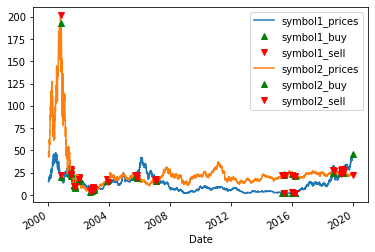

In [128]:
# we visualize the graph again
pair_strategy['symbol1_price'].plot()
pair_strategy.symbol1_buy[pair_strategy.symbol1_buy != 0].plot(color = 'g',marker = '^',linestyle = 'None')
pair_strategy.symbol1_sell[pair_strategy.symbol1_sell != 0].plot(color = 'r',marker = 'v',linestyle = 'None')

symbol2_prices.plot()
pair_strategy.symbol2_buy[pair_strategy.symbol2_buy != 0].plot(color = 'g',marker = '^',linestyle = 'None')
pair_strategy.symbol2_sell[pair_strategy.symbol2_sell != 0].plot(color = 'r',marker = 'v',linestyle = 'None')
plt.legend(['symbol1_prices','symbol1_buy','symbol1_sell','symbol2_prices','symbol2_buy','symbol2_sell'])

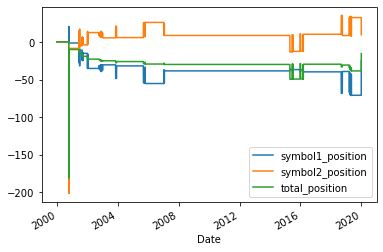

In [136]:
# we can see that now our buy/sell actions become more clear
# now we want to calculate our positions
# long position: positive
# short position: negative
pair_strategy['symbol1_position'] = pair_strategy['symbol1_buy'] - pair_strategy['symbol1_sell']
pair_strategy['symbol2_position'] = pair_strategy['symbol2_buy'] - pair_strategy['symbol2_sell']
pair_strategy['total_position'] = pair_strategy['symbol1_position']+pair_strategy['symbol2_position']

# we plot the positions and total positions and the profits and loss
# since we use (buy - sell) to represent positions, 
# the negative total position actually represents positive profits
pair_strategy['symbol1_position'].cumsum().plot()
pair_strategy['symbol2_position'].cumsum().plot()
pair_strategy['total_position'].cumsum().plot()
plt.legend()

In [ ]:
# this is just a very simple example, since we buy one share
# in reality, for the purporse of delta netural, we need to adjust the size of shares we need to buy